This is a copy of "Learning_True_CB_alevin". Here we are focusing on the output from running alevin on the t_4k data

Here we want to test whether we can use ML methods to identify the true CBs, inspired by the DropEst BioRxiv manuscript.
Many of the features can be obtained from alevin using the --dumpfeatures option which provides files with
* \# reads per CB (frequency.txt)
* \# mapped reads (MappedUmi.txt)

We can also obtain the # reads per CB post deduplication by summing up the counts in the CB/quant.sf file. From these three metrics we can obtain 
* Fraction of non-genic reads
* Duplication rate

We are also going to use
* Fraction of Mt reads (This was used in DropEst as a hard threshold. We want to see whether it's useful to include in ML)
* Fraction of rRNA reads (I don't this this was used in DropEst at all?)
* Some measure(s) of expression distribution
* Mean CB quality (This is currently unavailable - need to ask Avi to dump this too)
* Max correlation with true cells


In [1]:
import glob
import os
import pandas as pd
import numpy as np
import sqlite3
import scipy
from datetime import datetime

from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

%load_ext rpy2.ipython
%matplotlib inline  

Find the quantification outfiles

In [4]:
# glob.glob very slow with [...]/cell/*/quant.sf for some reason. We know each subdirectory will contain a quant.sf file
quant_files = [os.path.join(x, "quant.sf") for x in glob.glob("../whitelisting/alevin_run/test_t_4k/alevin/cell/*")]
print(len(quant_files))

6076


tally the CB counts and # 'mapped' reads per CB (to get dedup rate)

In [6]:
CB_counts = {}
CB_mapped_counts = {}

true_cells = set()
false_cells = set()
ambiguous_cells = set()

with open("../whitelisting/alevin_run/test_t_4k/alevin/frequency.txt") as inf:
    for ix, line in enumerate(inf):
        cell, count = line.strip().split("\t")
        CB_counts[cell] = int(count)
        if ix < (len(quant_files)-1000)/2: # top 50% of cells
            true_cells.add(cell)
        elif ix < len(quant_files)-1000:
            ambiguous_cells.add(cell)
        else:
            false_cells.add(cell)
            
with open("../whitelisting/alevin_run/test_t_4k/alevin/MappedUmi.txt") as inf:
    for line in inf:
        cell, count = line.strip().split("\t")
        CB_mapped_counts[cell] = int(count)
        
        


In [7]:
# Check we have the right number of CBs in each group
print(len(true_cells), len(false_cells), len(ambiguous_cells))
print(ix)

2538 1000 2538
6075


In [9]:
# Check we have the same numeber of CBs in the counts and mapped counts counters
print(len(CB_counts))
print(len(CB_mapped_counts))

6076
6076


In [11]:
# Read in the quant data
dedup_counts = pd.read_table(quant_files[0], sep="\t", usecols=[0,2], index_col=0)
sample_name = quant_files[0].split("/")[-2]
dedup_counts.columns = [sample_name]
gene_n = len(dedup_counts.index)

print(dedup_counts.shape)

no_quant = set()
n = 1
total_to_complete = len(quant_files[1:])
start_time = datetime.now()
for infile in quant_files[1:]:
    print("processed %i predicted finish: %s\r" % (
        n, (start_time + ((datetime.now()-start_time)*(total_to_complete/n))).strftime('%Y-%m-%d %H:%M:%S')),
          end="")
    n+=1

    sample_name = infile.split("/")[-2]
    tmp_counts = np.zeros(gene_n)
    
    if not os.path.exists(infile):
        no_quant.add(sample_name)
        continue
        
    with open(infile, "r") as inf:
        header = next(inf)
        for ix, line in enumerate(inf):
            tmp_counts[ix] = line.strip().split("\t")[-1]
    dedup_counts[sample_name] = tmp_counts

print("processed all: ", n, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(dedup_counts.shape)
print(dedup_counts.head())
    
    


(197357, 1)


KeyboardInterrupt: 

In [18]:
#subset the quant to only those transcripts with non-zero quant in at least one cell!
print(dedup_counts.shape)
keep_transcript = dedup_counts.sum(axis=1)>0
print(sum(keep_transcript))
dedup_counts = dedup_counts.loc[keep_transcript,:]
print(dedup_counts.shape)

(197357, 6076)
140070
(140070, 6076)


In [19]:
# get the dedup rate
print(no_quant)
print(len(CB_mapped_counts))
print(dedup_counts.shape)
dedup_rate = {}
alignment_rate = {}
for cell in CB_mapped_counts:
    if cell not in dedup_counts.columns:
        if cell not in no_quant:
            print("cell not in dedup counts dataframe but not recorded as having no quant data! - %s" % cell)
    else:
        alignment_rate[cell] =  CB_mapped_counts[cell] / CB_counts[cell]       
        
        sum_deduped = sum(dedup_counts[cell])
        dedup_rate[cell] = 1-(sum_deduped/CB_mapped_counts[cell])
        
    

set()
6076
(140070, 6076)


In [12]:
# We need to identify the mitochondrial genes. Here we'll simply read these genes in 

mt_genes = set()
with open("./mt_genes.tsv", "r") as infile:
    for line in infile:
        mt_genes.add(line.strip().split("\t")[0])
print(len(mt_genes))

37


In [13]:
mt_fraction = {}
mt_counts = dedup_counts.loc[mt_genes]
mt_fraction = mt_counts.sum(axis=0)/dedup_counts.sum(axis=0)
    

We need a map between transcripts and genes to obtain the gene-level expression estimates. We could just use the transcript-level abundance but the gene-level abundance is likely to be less noisy for the correlation purposes we want to use if for here. Again, here, we read this transcript2gene map in from a flatfile

In [25]:
transcript2gene = {}
with open("./transctipt2gene", "r") as inf:
    for line in inf:
        transcript, gene = line.strip().split("\t")
        transcript2gene[transcript] = gene


In [26]:
gene_dedup_counts = dedup_counts.groupby([transcript2gene[x] for x in dedup_counts.index]).aggregate(np.sum)

In [14]:
# We also need to identify the rRNA genes. Here we'll simply read these genes in

rRNA_genes = set()
with open("./rrna_genes.tsv", "r") as infile:
    for line in infile:
        rRNA_genes.add(line.strip().split("\t")[0])

rRNA_counts = gene_dedup_counts.loc[rRNA_genes]
rRNA_fraction = rRNA_counts.sum(axis=0)/gene_dedup_counts.sum(axis=0)

In [29]:
ratio_mean_max = {}
over_mean = {}
for cell in alignment_rate:
    expression_values = [x for x in gene_dedup_counts[cell] if x>0]
    mean_expression = np.mean(expression_values)
    ratio_mean_max[cell] = mean_expression / np.max(expression_values)  
    over_mean[cell] = sum([x > mean_expression for x in expression_values]) / len(expression_values)

Get the correlation with the true cells, excl. correlation with itself of course! We'll pre-compute ranks to save time.

In [30]:
print(gene_dedup_counts.ix[1:3,1:3])
print("ENSG00000010610" in gene_dedup_counts.index)
print(gene_dedup_counts.ix['ENSG00000010610', 1:10])
print(gene_dedup_counts.ix['ENSG00000153563', 1:10])

                 TACGGTATCCTGCTTG  CCCATACTCACGGTTA
ENSG00000000419               0.0               0.0
ENSG00000000457               0.0               0.0
True
TACGGTATCCTGCTTG    0.0
CCCATACTCACGGTTA    0.0
ACGATACGTGAAATCA    0.0
ACGCCGAGTACACCGC    0.0
GCGCAACAGCATGGCA    0.0
CGCTATCAGAGTAATC    1.0
CGTGTAAGTTCACCTC    0.0
CAAGAAAGTATATGGA    1.0
CTACGTCGTCTCTCTG    0.0
Name: ENSG00000010610, dtype: float64
TACGGTATCCTGCTTG    0.000000
CCCATACTCACGGTTA    5.000010
ACGATACGTGAAATCA    0.000000
ACGCCGAGTACACCGC    0.000000
GCGCAACAGCATGGCA    0.999999
CGCTATCAGAGTAATC    0.000000
CGTGTAAGTTCACCTC    6.999990
CAAGAAAGTATATGGA    0.000000
CTACGTCGTCTCTCTG    0.999999
Name: ENSG00000153563, dtype: float64


/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [31]:
keep_genes = list(gene_dedup_counts.sum(axis=1).sort_values(ascending=False)[0:1000].index)
keep_genes.extend(["ENSG00000153563", "ENSG00000010610"])
top_1000_genes_dedup_counts = gene_dedup_counts.ix[keep_genes]
true_cell_arrays = {}
for cell in true_cells:
    true_cell_arrays[cell] = scipy.stats.rankdata(top_1000_genes_dedup_counts[cell])

In [33]:
# obtain the max correlation with the true CBs
start = datetime.now()
print("processed 0 cells %s" % (datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
n = 0
cor_with_true = {} # best correlation
for cell in top_1000_genes_dedup_counts.columns:
    #print(cell)
    cell_exp_array = scipy.stats.rankdata(top_1000_genes_dedup_counts[cell])
    
    max_cor = -1
    for true_cell in true_cells:
        if true_cell == cell: # skip correlation with itself!
            continue
        cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
        if cor > max_cor:
            max_cor = cor
        if cor == 1:
            print(true_cell, cell, true_cell_arrays[true_cell][0:10], cell_exp_array[0:10])
            break
    
    cor_with_true[cell] = max_cor
        
    n+=1
    print("processed %i cells. Predicted finish: %s\r" % (
        n, (start + (datetime.now()-start)*(len(CB_counts)/n)).strftime('%Y-%m-%d %H:%M:%S')), end="")
    

print("processed all %i cells %s" % (n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

processed 0 cells 2018-01-10 12:57:31


/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


processed all 6076 cells 2018-01-10 13:08:20-01-10 13:08:20


In [34]:
# write the quant out to avoid re-obtaining for e.g PCA analysis    
top_1000_genes_dedup_counts.to_csv("t_4k_top_1000_genes_quant.tsv", sep="\t")

ACGGGTCGTAAGTGTA


In [35]:
# make the features dataframe

features = pd.DataFrame([alignment_rate, dedup_rate, mt_fraction, rRNA_fraction,
                         ratio_mean_max, over_mean, cor_with_true]).transpose()
features.columns = ["alignment", "duplication", "mt", "rRNA", "mean_max", "over_mean", "cor"]
features["cb_counts"] = [CB_counts[cell] for cell in features.index]

In [36]:
# add the CB type info

def getCellType(cb, true_cells, false_cells, ambiguous_cells):
    if cb in true_cells:
        return("true")
    elif cb in false_cells:
        return("false")
    elif cb in ambiguous_cells:
        return("ambiguous")
    else:
        raise ValueError("unknown cell type!")


features['cell_type'] = [getCellType(x, true_cells, false_cells, ambiguous_cells) for x in features.index]

print(features.head())

                  alignment  duplication        mt      rRNA  mean_max  \
AAAAAAAAAAAAAAAA   0.405825     0.588517  0.000000  0.000000  0.136943   
AAACCTGAGTGAAGAG   0.713743     0.695569  0.018482  0.000175  0.020639   
AAACCTGCAAACCTAC   0.737554     0.706078  0.013803  0.000000  0.018128   
AAACCTGCAACGATCT   0.514577     0.812848  0.131230  0.000000  0.006854   
AAACCTGCACTGCCAG   0.735852     0.711884  0.017907  0.000000  0.016154   

                  over_mean       cor  cb_counts  cell_type  
AAAAAAAAAAAAAAAA   0.159236  0.149945       1030      false  
AAACCTGAGTGAAGAG   0.102052  0.592329      52645  ambiguous  
AAACCTGCAAACCTAC   0.099524  0.580835      58713       true  
AAACCTGCAACGATCT   0.149317  0.350113      20238  ambiguous  
AAACCTGCACTGCCAG   0.112807  0.598213      57464  ambiguous  


In [37]:
use_metrics = ["alignment", "duplication", "mt", "rRNA", "mean_max", "over_mean", "cor"]

In [38]:
# Split-out validation dataset
ml_df = features[[x in ["true", "false"] for x in features['cell_type']]]
     
X = ml_df.loc[:,use_metrics].values
Y = ml_df['cell_type'].values
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

scoring = 'accuracy'


In [39]:
def predictCellType(features, ml):
    X_full = features.loc[:,use_metrics].values
    predictions = ml.predict(X_full)
    probs = [x[1] for x in ml.predict_proba(X_full)]
    print(features['cell_type'].value_counts())
    print(confusion_matrix(features['cell_type'], predictions))
    print("\n\n")
    return(predictions, probs)

In [40]:
def testNBPriors(prior_values=False):
    if prior_values:
        ml = GaussianNB(prior_values)
    else:
        ml = GaussianNB()
    ml.fit(X_train, Y_train)
    predictions = ml.predict(X_validation)
    x = predictCellType(features[[x not in ["true", "false"] for x in features['cell_type']]], ml)
    predictions, probs = predictCellType(features, ml)
    features['pred'] = predictions
    features['prob'] = probs
    return(features)

In [41]:
cell_type_counts = features['cell_type'].value_counts()
prob_true = cell_type_counts['true'] / (cell_type_counts['true'] + cell_type_counts['false'])
#print(cell_type_counts, "\n")

# Check whether
df_NB_unequal1 = testNBPriors([prob_true, 1-prob_true])
df_NB = testNBPriors()

ambiguous    2538
Name: cell_type, dtype: int64
[[   0  912 1626]
 [   0    0    0]
 [   0    0    0]]



ambiguous    2538
true         2538
false        1000
Name: cell_type, dtype: int64
[[   0  912 1626]
 [   0 1000    0]
 [   0   37 2501]]



ambiguous    2538
Name: cell_type, dtype: int64
[[   0  888 1650]
 [   0    0    0]
 [   0    0    0]]



ambiguous    2538
true         2538
false        1000
Name: cell_type, dtype: int64
[[   0  888 1650]
 [   0 1000    0]
 [   0   32 2506]]





In [42]:
ml = GaussianNB()#[prob_true, 1-prob_true])
ml.fit(X_train, Y_train)
predictions = ml.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.992937853107
[[206   0]
 [  5 497]]
             precision    recall  f1-score   support

      false       0.98      1.00      0.99       206
       true       1.00      0.99      0.99       502

avg / total       0.99      0.99      0.99       708



In [43]:
predictions, probs = predictCellType(features, ml)
features['pred'] = predictions
features['prob'] = probs

ambiguous    2538
true         2538
false        1000
Name: cell_type, dtype: int64
[[   0  888 1650]
 [   0 1000    0]
 [   0   32 2506]]





In [44]:
%%R 
library(ggplot2)

my_theme <- theme_bw() + theme(text=element_text(size=20), panel.grid=element_blank(), aspect.ratio=1)

makePCA <- function(df, use_metrics){
    pca <- prcomp(t(df[,match(use_metrics,colnames(df))]))
    projections <- data.frame(pca$rotation)
    projections <- merge(projections, df, by="row.names")
    return(projections)
}


printPCA <- function(projections, x="PC1", y="PC2", lim=T, colour_by=F, facet_by=F, facet_by_y=F){
    p <- ggplot(projections, aes_string(x, y)) + geom_point() + my_theme
    
    if(lim){
    p <- p + xlim(c(quantile(projections[[x]], c(0.01, 0.99)))) +
        ylim(c(quantile(projections[[y]], c(0.01, 0.99))))
    }
    
    if(!missing(colour_by)){
        p <- p + aes_string(colour=colour_by)
    }
    
    if(!missing(facet_by)){
        if(!missing(facet_by_y)){
            p <- p  + facet_wrap(as.formula(sprintf("%s~%s", facet_by, facet_by_y)))
        }
        else{
            p <- p + facet_wrap(as.formula(sprintf("~%s", facet_by)))
        }
    }

    print(p)
}

printPCs <- function(projections, ...){
    printPCA(projections, ...)
    printPCA(projections, "PC3", "PC4", ...)
    printPCA(projections, "PC5", "PC6", ...)    
}


In [45]:
%%R -i features -i use_metrics

projections <- makePCA(features, use_metrics)

In [46]:
%%R
print(head(features))

                 alignment duplication         mt         rRNA    mean_max
AAAAAAAAAAAAAAAA 0.4058252   0.5885167 0.00000000 0.000000e+00 0.136942675
AAACCTGAGTGAAGAG 0.7137430   0.6955689 0.01848209 1.748405e-04 0.020638982
AAACCTGCAAACCTAC 0.7375539   0.7060780 0.01380253 0.000000e+00 0.018128436
AAACCTGCAACGATCT 0.5145765   0.8128481 0.13123002 0.000000e+00 0.006854253
AAACCTGCACTGCCAG 0.7358520   0.7118837 0.01790747 0.000000e+00 0.016153849
AAACCTGCAGGTGCCT 0.7728427   0.7133594 0.01180817 7.540333e-05 0.017197025
                  over_mean       cor cb_counts cell_type  pred          prob
AAAAAAAAAAAAAAAA 0.15923567 0.1499446      1030     false false  0.000000e+00
AAACCTGAGTGAAGAG 0.10205245 0.5923288     52645 ambiguous  true  9.999999e-01
AAACCTGCAAACCTAC 0.09952356 0.5808350     58713      true  true  1.000000e+00
AAACCTGCAACGATCT 0.14931651 0.3501132     20238 ambiguous false 2.343635e-149
AAACCTGCACTGCCAG 0.11280654 0.5982133     57464 ambiguous  true  1.000000e+00
AAACCTG

In [47]:
%%R
write.table(projections, sep="\t", file="t_4k_projections.tsv")

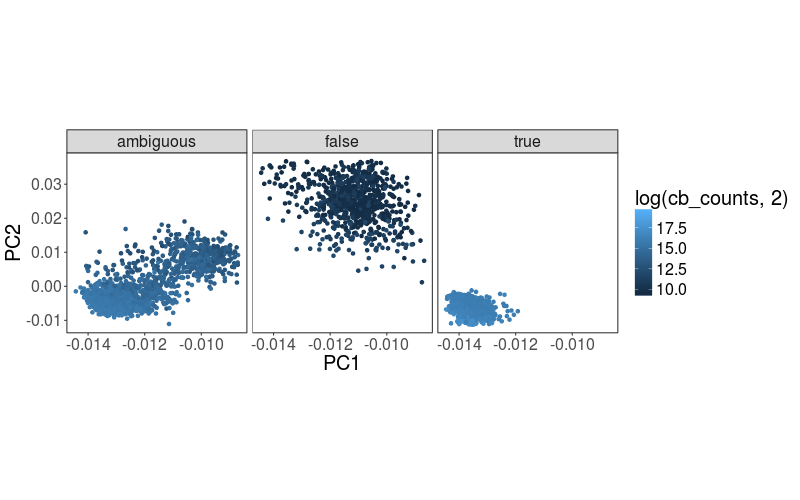

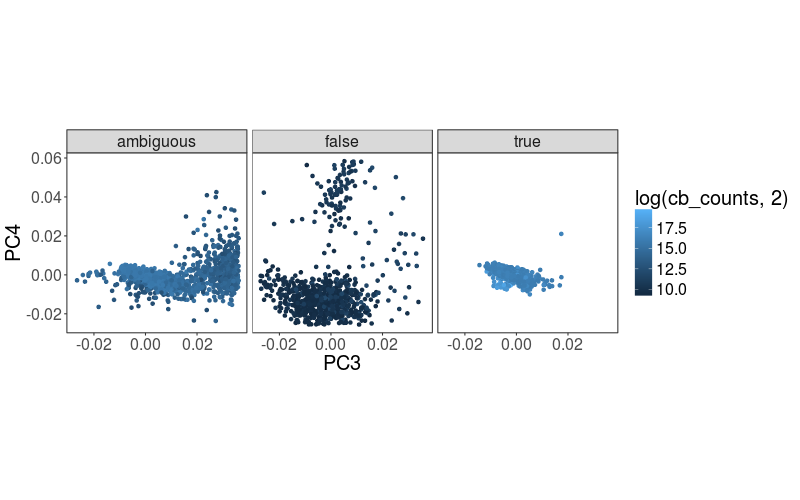

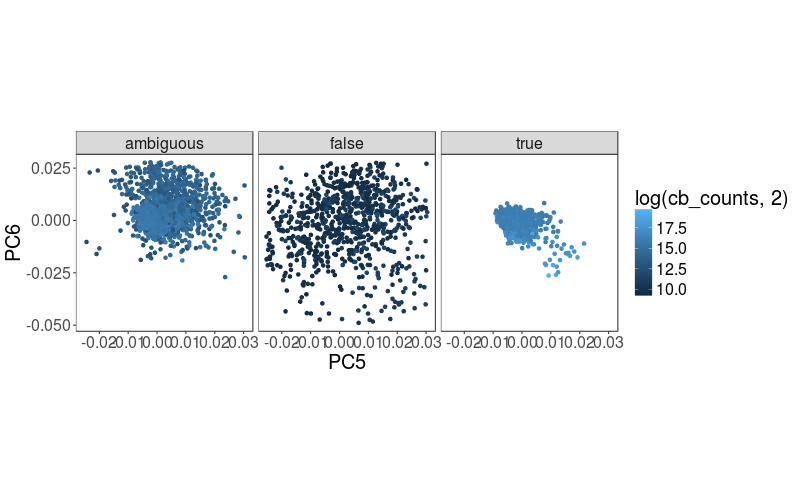

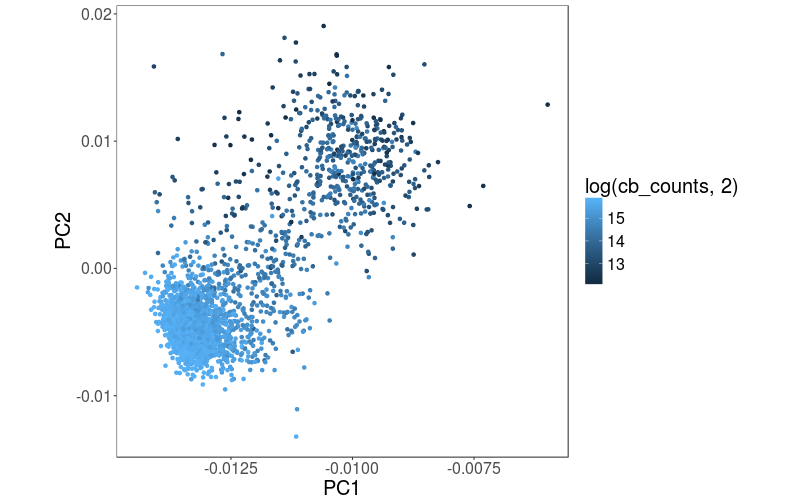

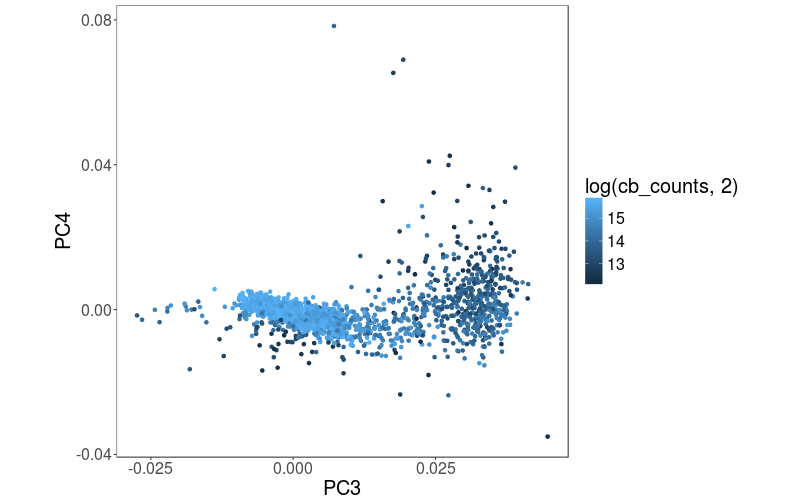

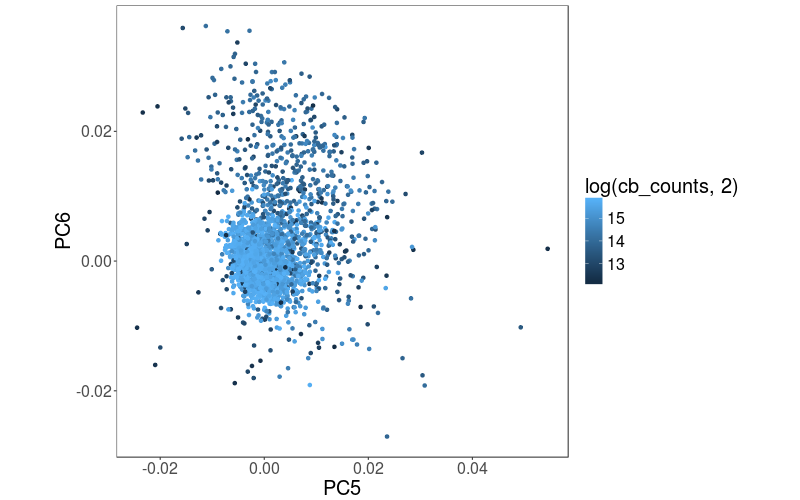

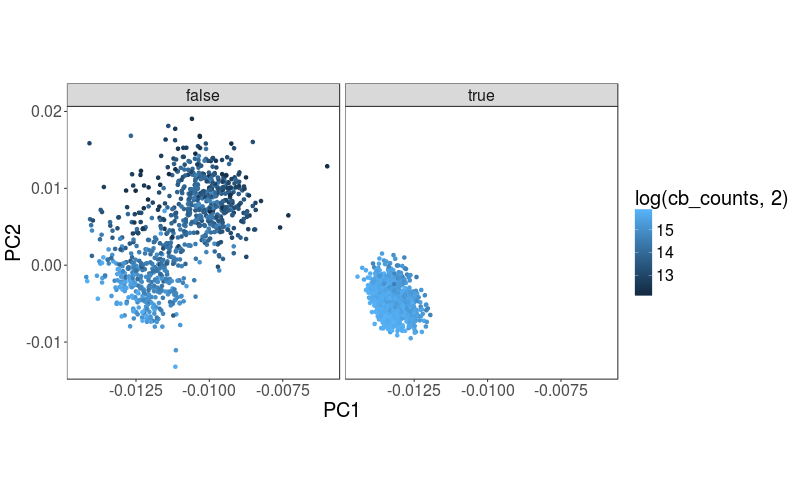

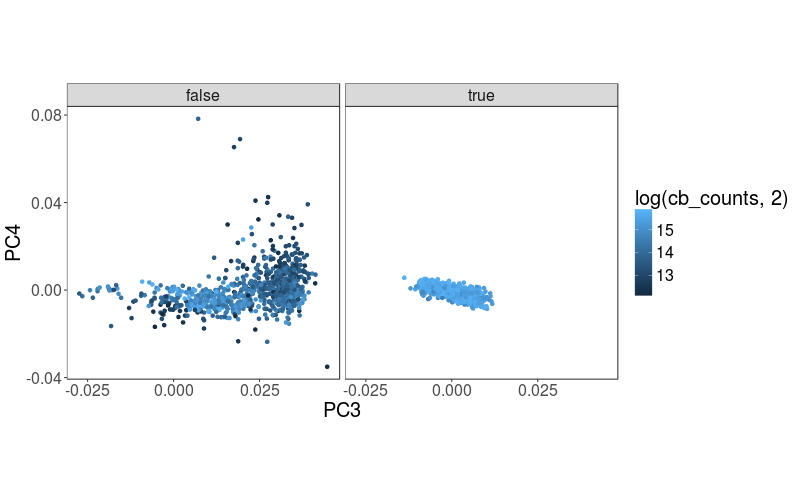

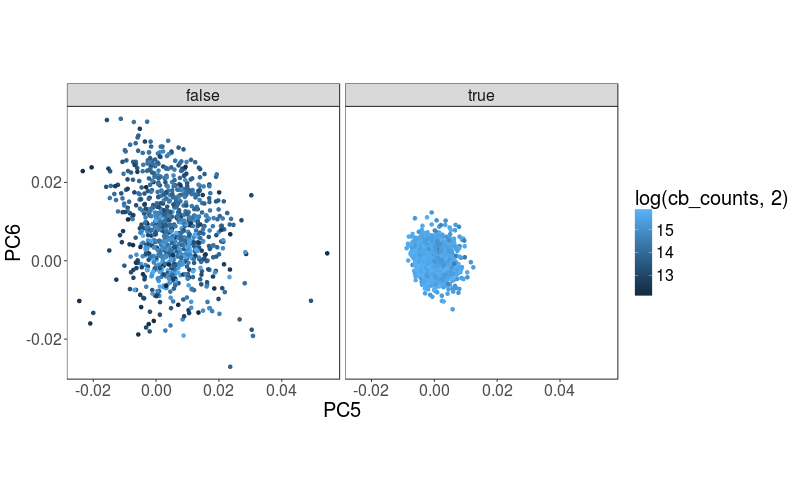

In [93]:
%%R -w 800 -h 500
printPCs(projections, colour_by="log(cb_counts,2)", facet_by="cell_type")

pca <- makePCA(features, use_metrics)
amb_cells <- rownames(features[features$cell_type=="ambiguous",])

printPCs(pca[pca$Row.names %in% amb_cells,], colour_by="log(cb_counts,2)", lim=F)

printPCs(pca[pca$Row.names %in% amb_cells,], colour_by="log(cb_counts,2)", facet_by="pred", lim=F)

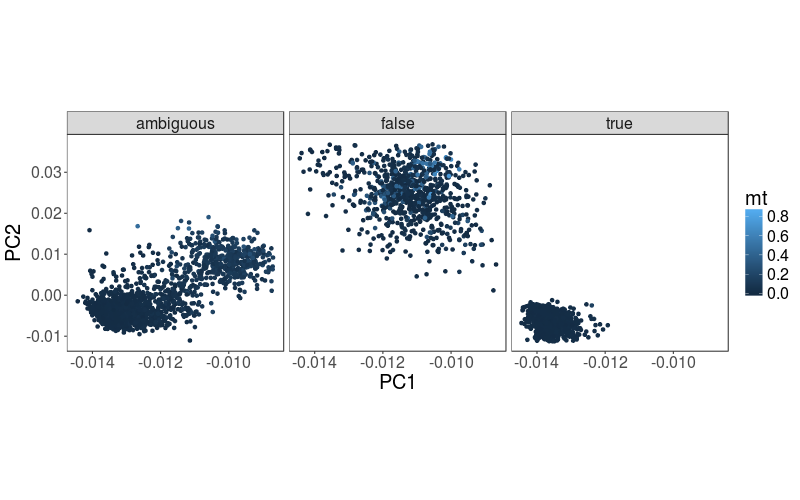

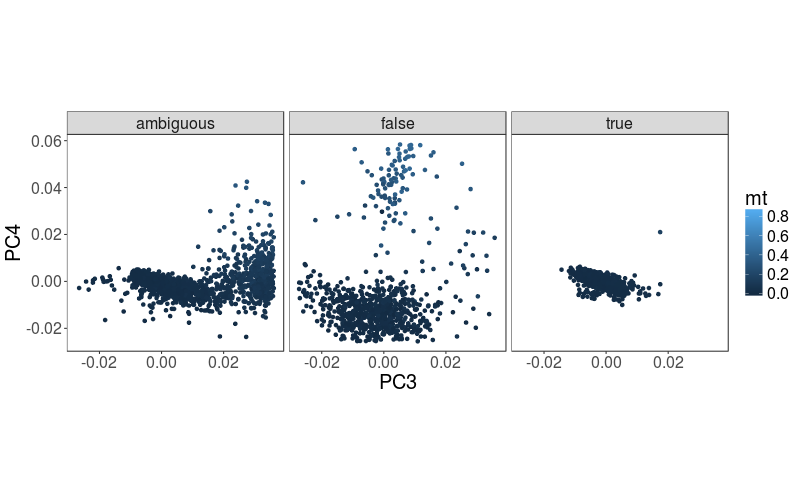

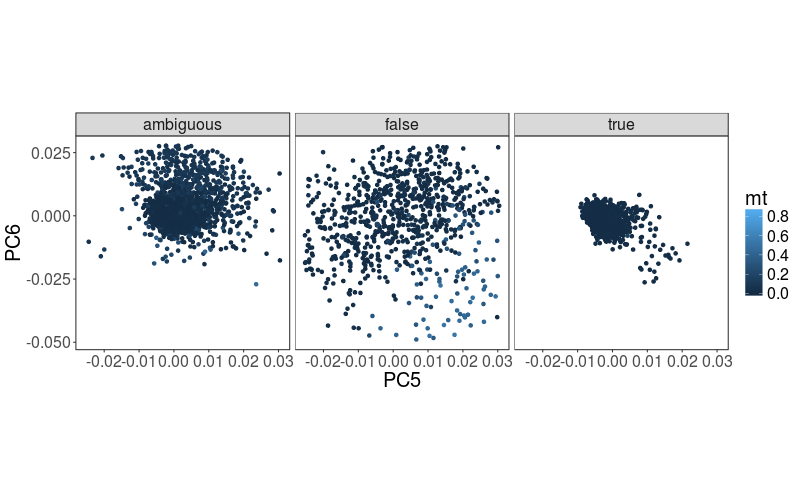

In [49]:
%%R -w 800 -h 500
printPCs(projections, colour_by="mt", facet_by="cell_type")

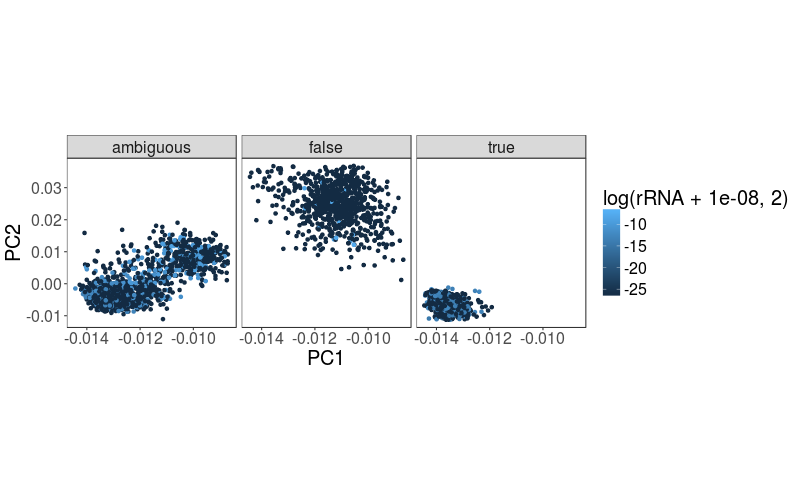

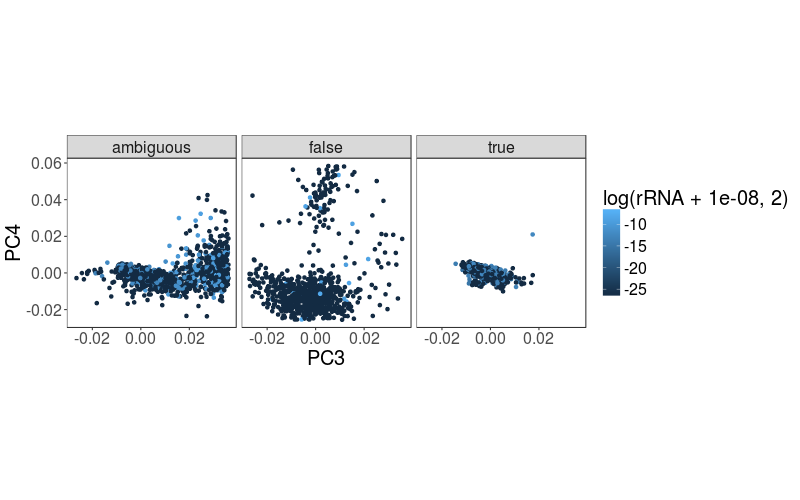

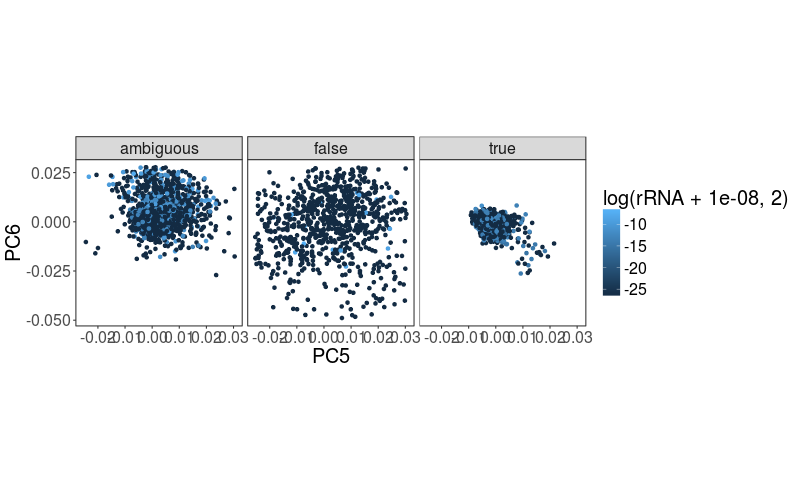

In [50]:
%%R -w 800 -h 500
printPCs(projections, colour_by="log(rRNA+0.00000001,2)", facet_by="cell_type")

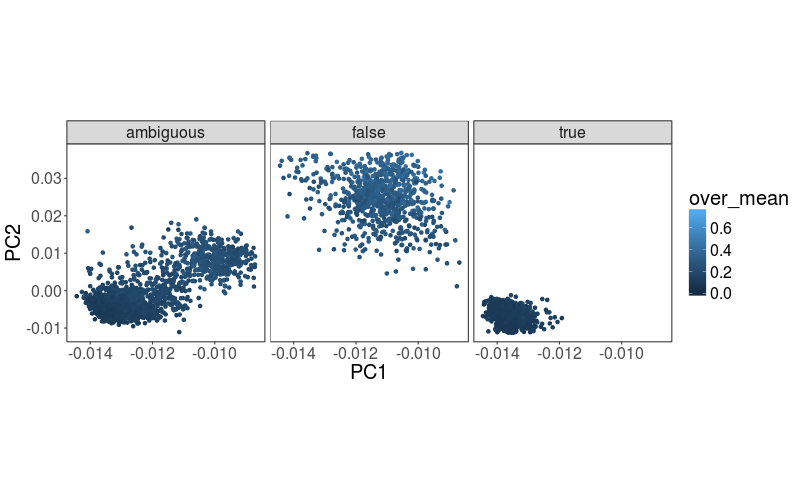

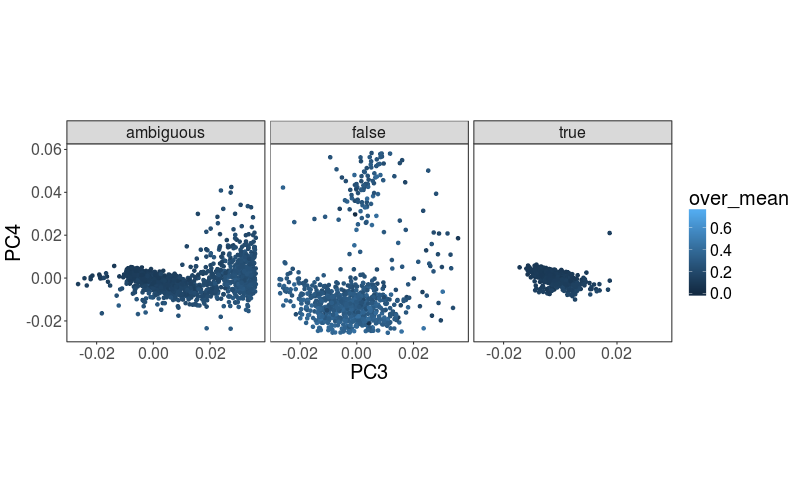

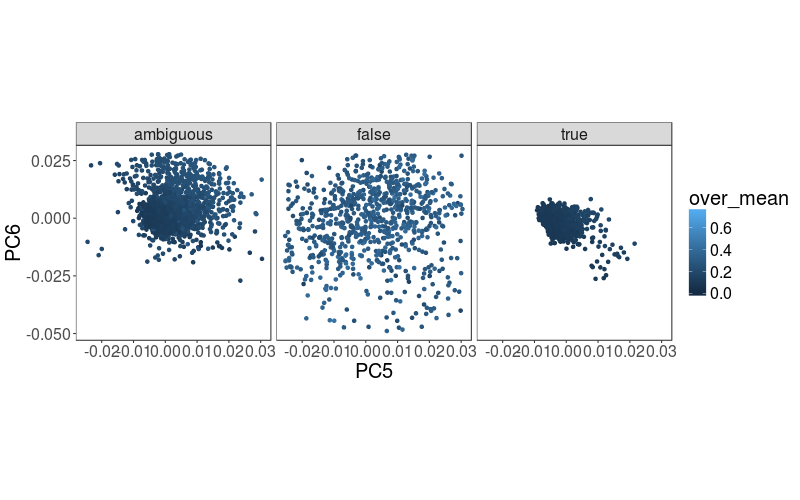

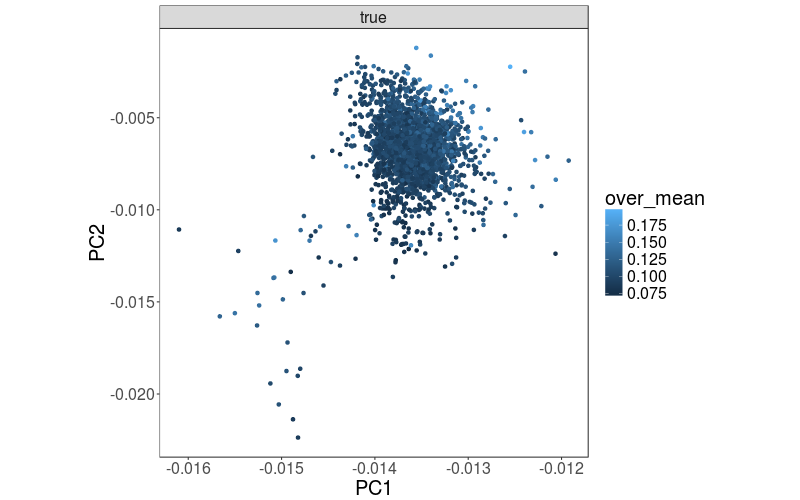

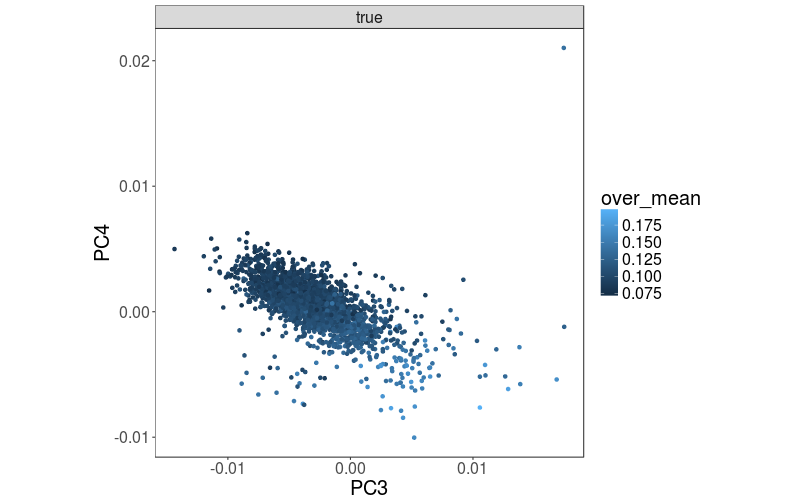

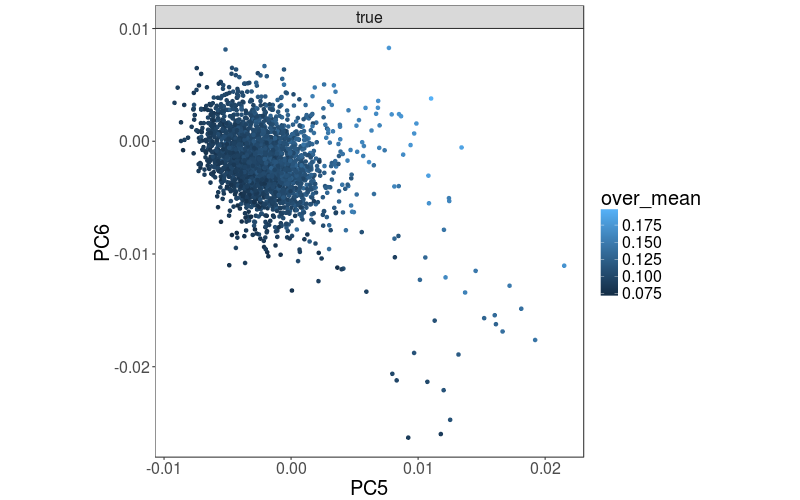

In [86]:
%%R -w 800 -h 500
printPCs(projections, colour_by="over_mean", facet_by="cell_type")

pca <- makePCA(features, use_metrics)
true_cells <- rownames(features[features$cell_type=="true",])

printPCs(pca[pca$Row.names %in% true_cells,], colour_by="over_mean", facet_by="cell_type", lim=F)

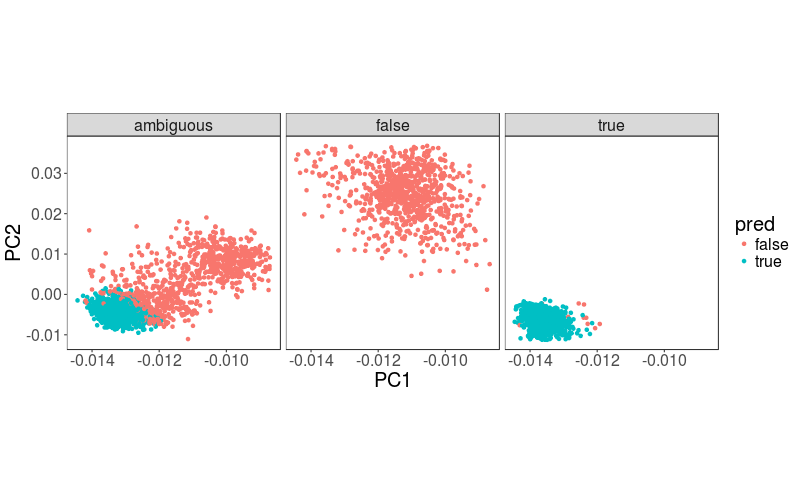

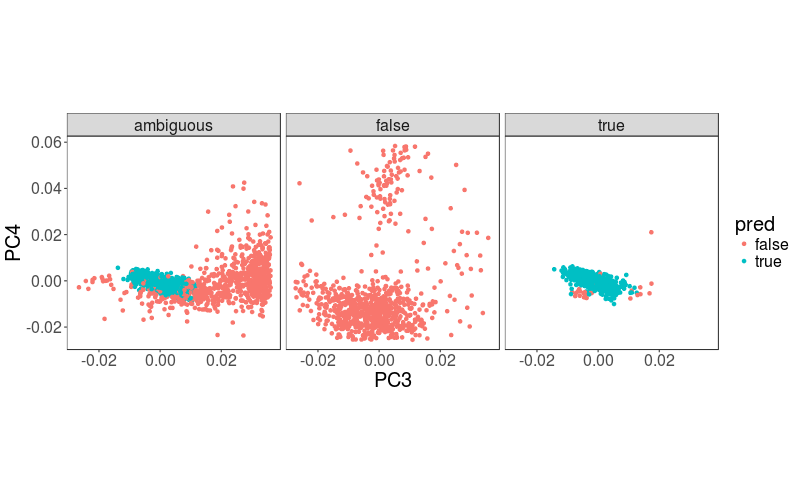

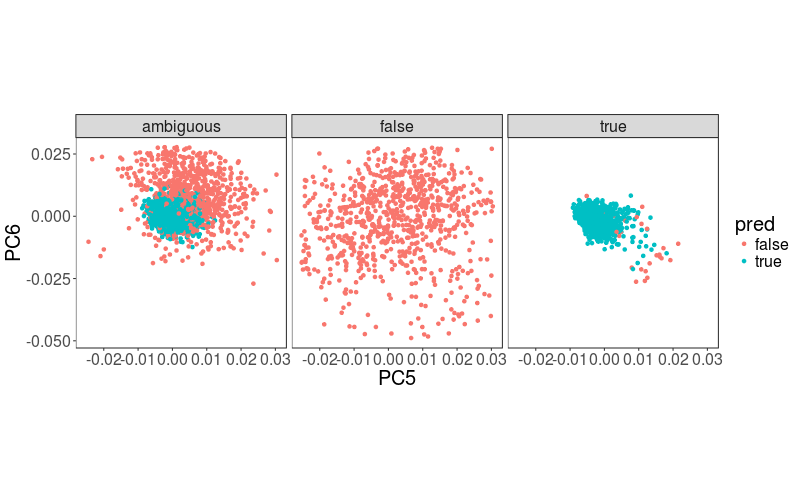

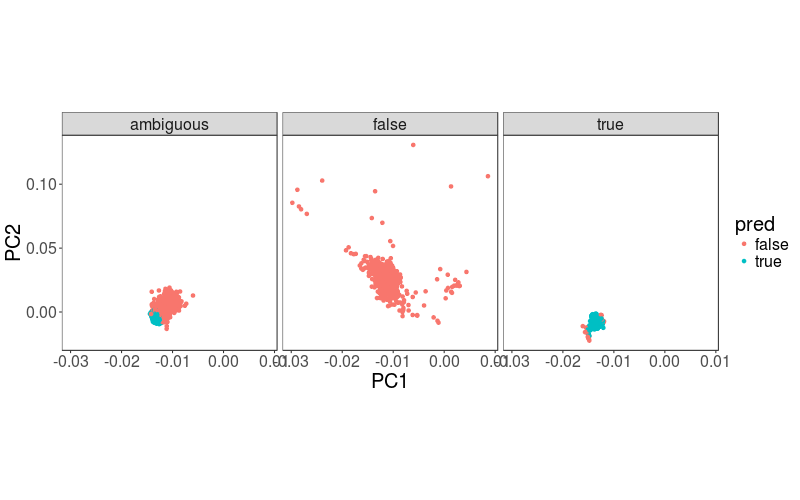

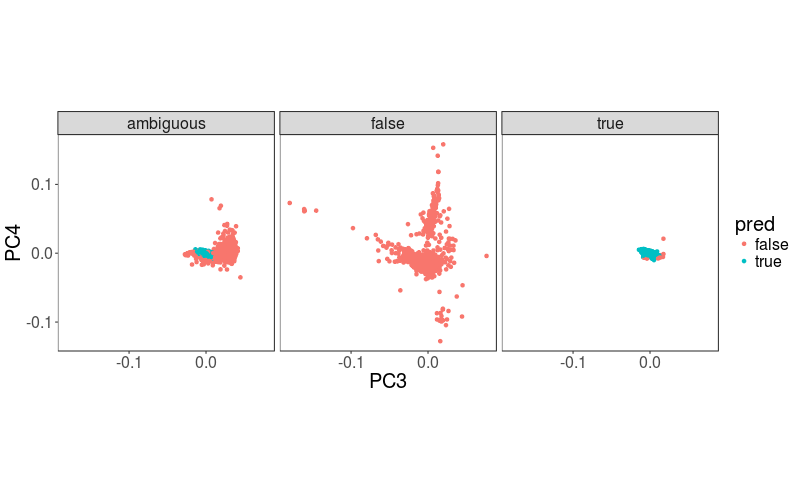

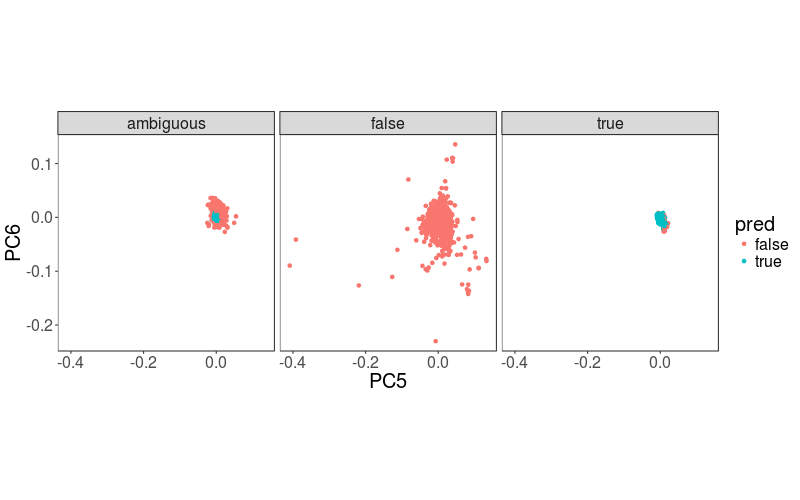

In [88]:
%%R -w 800 -h 500
printPCs(projections, colour_by="pred", facet_by="cell_type", lim=T)
printPCs(projections, colour_by="pred", facet_by="cell_type", lim=F)

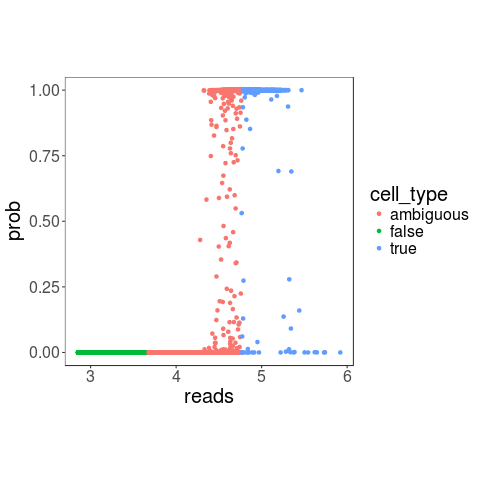

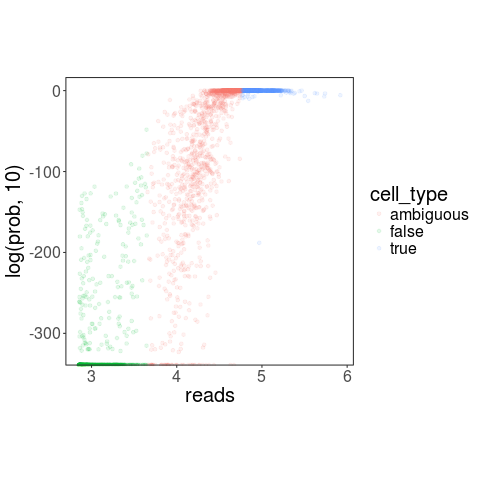

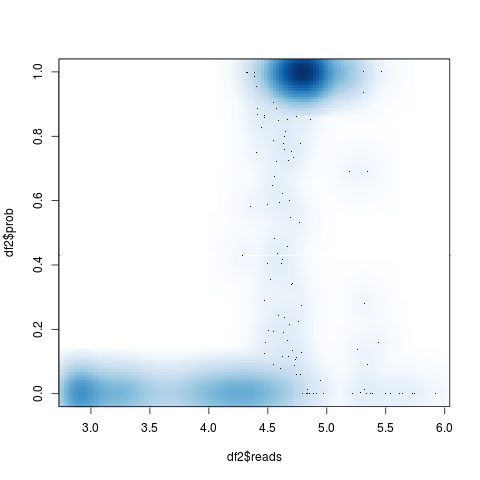

In [52]:
%%R
library(reshape2)
df2 = features
df2$reads = log(df2$cb_counts,10)

p <- ggplot(df2, aes(reads, prob, colour=cell_type)) +
geom_point() + my_theme
print(p)

p <- ggplot(df2, aes(reads, log(prob,10), colour=cell_type)) +
geom_point(alpha=0.1) + my_theme
print(p)

smoothScatter(df2$reads, df2$prob)

In [57]:
%%R
#print()
pca <- prcomp(t(features[,match(use_metrics,colnames(features))]))
print(pca$x)

                  PC1        PC2        PC3         PC4        PC5         PC6
alignment   -31.78554  4.2563134 -5.2409580  0.90169390  0.1011159  0.16298729
duplication -31.17878  1.2361965  5.7277927  0.27352853 -0.8134560  0.19460277
mt           21.68422 -0.1514086  1.0947489  3.84859555  0.6656896 -0.45091046
rRNA         24.07911 -2.4072252 -0.9521461 -0.05267886 -0.6073155  1.35200549
mean_max     21.31891  1.7822469 -1.1589589 -1.45468895 -1.5885319 -0.89028449
over_mean    12.47016  4.0901429  1.5375492 -2.48862355  1.6898693  0.04609739
cor         -16.58808 -8.8062659 -1.0080279 -1.02782662  0.5526286 -0.41449800
                      PC7
alignment    1.146521e-13
duplication  1.439972e-14
mt          -6.749928e-14
rRNA        -2.247161e-14
mean_max    -4.608542e-14
over_mean   -1.146839e-14
cor          1.638536e-14
